<a href="https://colab.research.google.com/github/vadhri/distibuted-optimization/blob/main/RestrictingOptimizationSurface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Converged after 271 iterations.
Initial point (u, v): (1.0000, 0.7854)
Initial point (x, y, z): (0.7071, 0.7071, 1.0000)
Final point (u, v): (0.0000, 0.7854)
Final point (x, y, z): (0.0000, 0.0000, 0.0000)
Objective function value: 0.0000
Path length: 272 points
Final point satisfies the cone constraint.


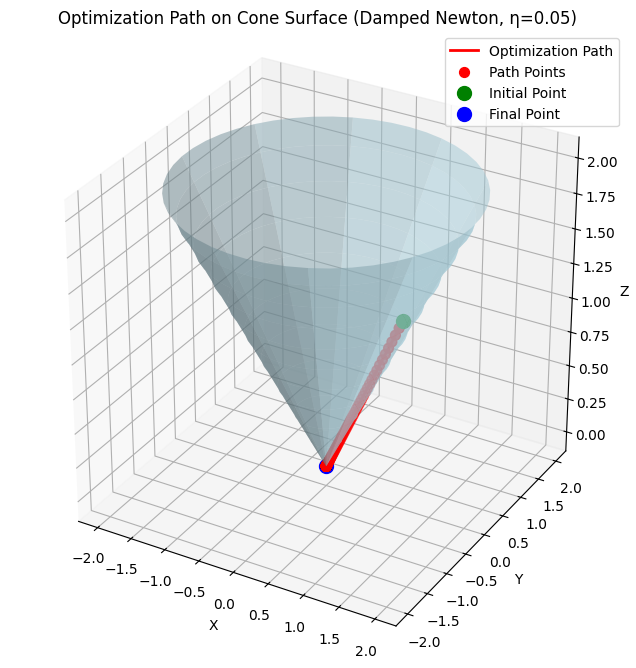

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Cone parameter
k = 1.0

# Learning rate
eta = 0.05

# Objective function: f(x, y, z) = x^2 + y^2 + z^2
def objective(u, v):
    x = k * u * np.cos(v)
    y = k * u * np.sin(v)
    z = u
    return x**2 + y**2 + z**2

# Gradient
def gradient(u, v):
    x = k * u * np.cos(v)
    y = k * u * np.sin(v)
    z = u
    df_dx = 2 * x
    df_dy = 2 * y
    df_dz = 2 * z
    df_du = df_dx * k * np.cos(v) + df_dy * k * np.sin(v) + df_dz
    df_dv = df_dx * (-k * u * np.sin(v)) + df_dy * (k * u * np.cos(v))
    return np.array([df_du, df_dv])

# Hessian
def hessian(u, v):
    d2f_dx2 = 2.0
    d2f_dy2 = 2.0
    d2f_dz2 = 2.0
    d2f_dxdy = 0.0
    d2f_dxdz = 0.0
    d2f_dydz = 0.0

    cos_v = np.cos(v)
    sin_v = np.sin(v)
    dx_du = k * cos_v
    dy_du = k * sin_v
    dz_du = 1.0
    dx_dv = -k * u * sin_v
    dy_dv = k * u * cos_v
    dz_dv = 0.0
    d2x_du2 = 0.0
    d2y_du2 = 0.0
    d2z_du2 = 0.0
    d2x_dv2 = -k * u * cos_v
    d2y_dv2 = -k * u * sin_v
    d2z_dv2 = 0.0
    d2x_dudv = -k * sin_v
    d2y_dudv = k * cos_v
    d2z_dudv = 0.0

    d2f_du2 = (d2f_dx2 * dx_du**2 + d2f_dy2 * dy_du**2 + d2f_dz2 * dz_du**2 +
               2 * d2f_dxdy * dx_du * dy_du + 2 * d2f_dxdz * dx_du * dz_du + 2 * d2f_dydz * dy_du * dz_du)
    d2f_dudv = (d2f_dx2 * dx_du * dx_dv + d2f_dy2 * dy_du * dy_dv + d2f_dz2 * dz_du * dz_dv +
                d2f_dxdy * (dx_du * dy_dv + dy_du * dx_dv) + d2f_dxdz * (dx_du * dz_dv + dz_du * dx_dv) +
                d2f_dydz * (dy_du * dz_dv + dz_du * dy_dv))
    d2f_dv2 = (d2f_dx2 * dx_dv**2 + d2f_dy2 * dy_dv**2 + d2f_dz2 * dz_dv**2 +
               2 * d2f_dxdy * dx_dv * dy_dv + 2 * d2f_dxdz * dx_dv * dz_dv + 2 * d2f_dydz * dy_dv * dz_dv)

    df_dx = 2 * (k * u * cos_v)
    df_dy = 2 * (k * u * sin_v)
    df_dz = 2 * u
    d2f_du2 += df_dx * d2x_du2 + df_dy * d2y_du2 + df_dz * d2z_du2
    d2f_dudv += df_dx * d2x_dudv + df_dy * d2y_dudv + df_dz * d2z_dudv
    d2f_dv2 += df_dx * d2x_dv2 + df_dy * d2y_dv2 + df_dz * d2z_dv2

    # Regularization to prevent singularity
    hess = np.array([[d2f_du2, d2f_dudv], [d2f_dudv, d2f_dv2]])
    hess += np.eye(2) * 1e-6
    return hess

# Damped Newton method
def damped_newton_method(u0, v0, eta=0.05, max_iter=5, tol=1e-6):
    u, v = u0, v0
    path = [(u, v)]

    for i in range(max_iter):
        grad = gradient(u, v)
        hess = hessian(u, v)
        if np.abs(np.linalg.det(hess)) < 1e-10:
            print(f"Iteration {i}: Hessian is near-singular, using regularized Hessian.")
        update = np.linalg.solve(hess, grad)
        u -= eta * update[0]
        v -= eta * update[1]
        u = max(u, 0)
        path.append((u, v))
        if np.linalg.norm(update) < tol:
            print(f"Converged after {i+1} iterations.")
            break

    return u, v, path

# Convert parametric to Cartesian
def to_cartesian(u, v):
    x = k * u * np.cos(v)
    y = k * u * np.sin(v)
    z = u
    return x, y, z

# Run optimization
initial_u, initial_v = 1.0, np.pi/4
final_u, final_v, path = damped_newton_method(initial_u, initial_v, eta=eta, max_iter=500)

# Convert path to Cartesian
path_cartesian = [to_cartesian(u, v) for u, v in path]
x_path, y_path, z_path = zip(*path_cartesian)

# Print results
initial_x, initial_y, initial_z = to_cartesian(initial_u, initial_v)
final_x, final_y, final_z = to_cartesian(final_u, final_v)
print(f"Initial point (u, v): ({initial_u:.4f}, {initial_v:.4f})")
print(f"Initial point (x, y, z): ({initial_x:.4f}, {initial_y:.4f}, {initial_z:.4f})")
print(f"Final point (u, v): ({final_u:.4f}, {final_v:.4f})")
print(f"Final point (x, y, z): ({final_x:.4f}, {final_y:.4f}, {final_z:.4f})")
print(f"Objective function value: {objective(final_u, final_v):.4f}")
print(f"Path length: {len(path)} points")
if abs(final_x**2 + final_y**2 - k**2 * final_z**2) < 1e-6:
    print("Final point satisfies the cone constraint.")
else:
    print("Final point does not satisfy the cone constraint.")

# 3D Plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
u = np.linspace(0, 2, 50)
v = np.linspace(0, 2 * np.pi, 50)
U, V = np.meshgrid(u, v)
X_cone = k * U * np.cos(V)
Y_cone = k * U * np.sin(V)
Z_cone = U
ax.plot_surface(X_cone, Y_cone, Z_cone, color='lightblue', alpha=0.5, rstride=5, cstride=5)
ax.plot(x_path, y_path, z_path, 'r-', linewidth=2, label='Optimization Path')
ax.scatter(x_path, y_path, z_path, c='red', s=50, label='Path Points')
ax.scatter([x_path[0]], [y_path[0]], [z_path[0]], c='green', s=100, label='Initial Point')
ax.scatter([x_path[-1]], [y_path[-1]], [z_path[-1]], c='blue', s=100, label='Final Point')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Optimization Path on Cone Surface (Damped Newton, η=0.05)')
ax.legend()
ax.set_box_aspect([1, 1, 1])
plt.show()

# Prepare data for Chart.js
u_path, v_path = zip(*path)
chart_data = [{"x": u, "y": v} for u, v in path]

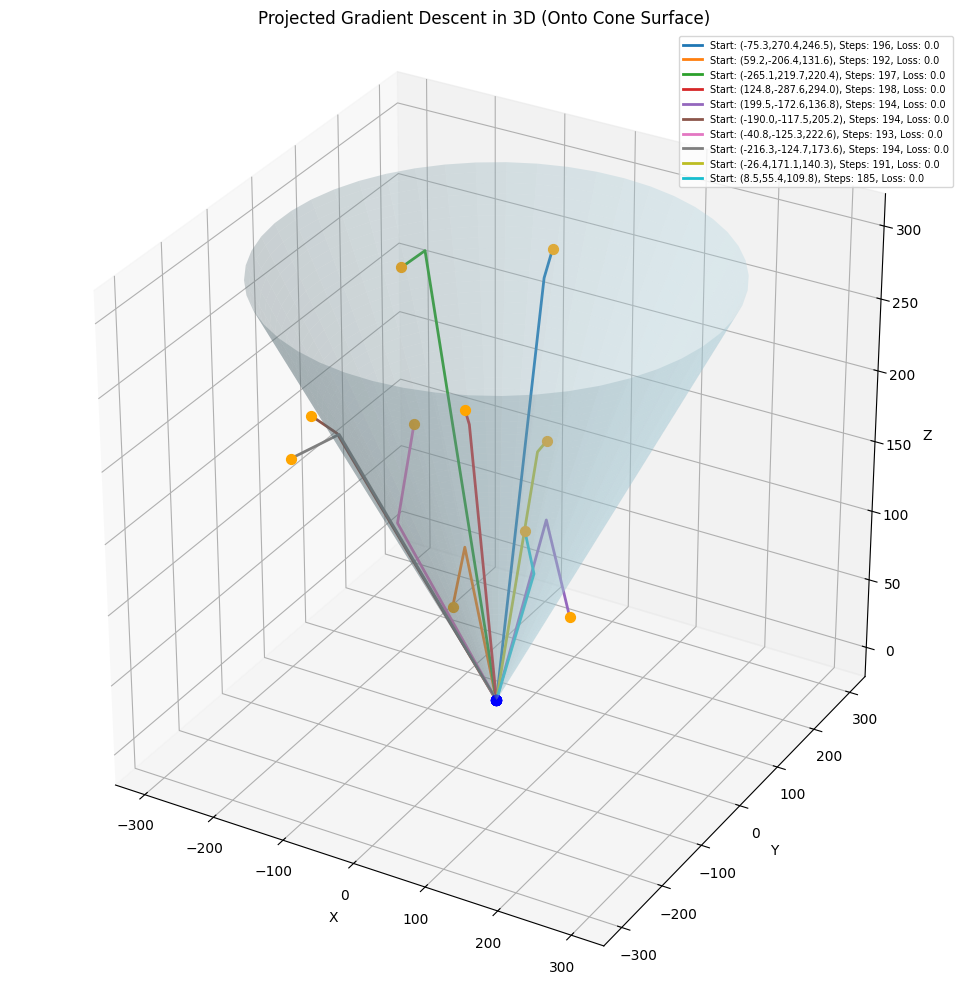

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import minimize

# Objective function in 3D
def objective_xyz(xyz):
    x, y, z = xyz
    return x**2 + y**2 + z**2

# Gradient of the objective
def grad_xyz(xyz):
    x, y, z = xyz
    return np.array([2*x, 2*y, 2*z])

# Projection onto the cone surface z = sqrt(x^2 + y^2)
def project_to_cone(xyz):
    x, y, z = xyz
    def proj_obj(p):
        return np.sum((p - xyz)**2)
    def cone_constraint(p):
        return p[2] - np.sqrt(p[0]**2 + p[1]**2)
    cons = {'type': 'eq', 'fun': cone_constraint}
    res = minimize(proj_obj, xyz, constraints=cons)
    return res.x

# Gradient descent with projection
def projected_gradient_descent_3d(xyz0, eta=0.1, max_iter=200, tol=1e-6):
    path = [xyz0]
    xyz = xyz0
    for i in range(max_iter):
        grad = grad_xyz(xyz)
        xyz = xyz - eta * grad
        xyz = project_to_cone(xyz)
        path.append(xyz)
        if np.linalg.norm(grad) < tol:
            break
    return np.array(path)

# Generate 10 random 3D starting points off the cone
np.random.seed(42)
start_points = [np.random.uniform([-300, -300, 100.5], [300, 300, 300]) for _ in range(10)]

# Run optimization
all_paths = []
labels = []
for p in start_points:
    path = projected_gradient_descent_3d(p, eta=0.05)
    all_paths.append(path)
    final_loss = objective_xyz(path[-1])
    labels.append(f"Start: ({p[0]:.1f},{p[1]:.1f},{p[2]:.1f}), Steps: {len(path)}, Loss: {final_loss:.1f}")

# Plot cone surface
u = np.linspace(0, 300, 500)
v = np.linspace(0, 2*np.pi, 50)
U, V = np.meshgrid(u, v)
X_cone = U * np.cos(V)
Y_cone = U * np.sin(V)
Z_cone = np.sqrt(X_cone**2 + Y_cone**2)

# Plot paths and surface
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X_cone, Y_cone, Z_cone, color='lightblue', alpha=0.3)

for i, path in enumerate(all_paths):
    x, y, z = path[:,0], path[:,1], path[:,2]
    ax.plot(x, y, z, linewidth=2, label=labels[i])
    ax.scatter([x[0]], [y[0]], [z[0]], c='orange', s=50)  # Start
    ax.scatter([x[-1]], [y[-1]], [z[-1]], c='blue', s=50)  # End

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("Fixed time - power newton method in 3D (Projected)")
ax.legend(loc='upper right', fontsize='x-small')
ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
plt.show()
